In [1]:
import boto3
import logging 
from botocore.exceptions import ClientError
import pandas as pd 
import io
import os
import numpy as np 

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Enable SSL certificate see https://stackoverflow.com/questions/71692354/facing-ssl-error-with-huggingface-pretrained-models
os.environ["CURL_CA_BUNDLE"]=""

## Machine learning Models - [text similarity](https://newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python#:~:text=In%20simple%20terms%2C%20similarity%20is,is%20called%20the%20similarity%20score) 
For text similarity model, we first vectorising the words and then calculate the similarity scores. We are focus on semantic similairty that is on the paragrahy level. 

- Baseline model: Term Frequency - Inverse Document Frequency (TF-IDF) + cosine similarity 
- Word2Vec + Cosine Similarity 
- BERT transformer + Cosine Similarity 

### Read in the text data 



In [46]:
filename = "records_cleaned_for_ml.parquet"
bucket_name = "webpresence-search-similarity-data-dev"

def open_s3_file(bucket, filename):
    """Open a S3 parquet file from bucket and filename and return the parquet as pandas dataframe
    :param bucket: Bucket name
    :param filename: Specific file name to open
    :return: body of the file as a string
    """
    try: 
        buffer = io.BytesIO()
        s3 = boto3.resource('s3')
        object = s3.Object(bucket, filename)
        object.download_fileobj(buffer)
        df = pd.read_parquet(buffer)
        
        return df
    except ClientError as e:
        logging.error(e)
        return False
    
df = open_s3_file(bucket_name, filename)

print('Data shape is', df.shape)
df.head()


Data shape is (6851, 7)


,features_properties_id,features_properties_title_en,features_properties_description_en,features_properties_keywords_en,text_en,title_en_cleaned,text_en_cleaned
0,000183ed-8864-42f0-ae43-c4313a860720,"Principal Mineral Areas, Producing Mines, and ...",This dataset is produced and published annuall...,"mineralization, mineral occurrences, mines, hy...","Principal Mineral Areas, Producing Mines, and ...",principal mineral areas producing mines oil ga...,principal mineral areas producing mines oil ga...
1,0005301b-624e-4000-8dad-a1a1ac6b46c2,Land Surface Evapotranspiration for Canada's L...,The dataset contains land surface evapotranspi...,"Land, Atmosphere, Ecosystems, Water, Meteorolo...",Land Surface Evapotranspiration for Canada's L...,land surface evapotranspiration canadas landmass,land surface evapotranspiration canadas landma...
2,000a51f1-3781-a262-35f2-ff83df4898d9,Licensed Lenders in Nova Scotia,Businesses licensed to extend credit or provid...,"lender, credit, borrowing, financing, Governme...",Licensed Lenders in Nova Scotia Businesses lic...,licensed lenders nova scotia,licensed lenders nova scotia businesses licens...
3,000c6ea0-fd88-6bb0-f901-a6e8b213f1c9,OD0139 PEI Confederation Trail,Available as an ESRI ArcGIS Shapefile. This da...,"Prince Edward Island data, Government information",OD0139 PEI Confederation Trail Available as an...,od0139 pei confederation trail,od0139 pei confederation trail available esri ...
4,001c30bd-0869-22a7-ef10-2284e8f9b560,Yukon Reference Information,Created for distribution by the GeoYukon appli...,"map, places, index, airphotos, communities, Go...",Yukon Reference Information Created for distri...,yukon reference information,yukon reference information created distributi...


In [50]:
# Prepare and slice the data for model comparison   
df = df[['features_properties_id', 'features_properties_title_en','title_en_cleaned', 'text_en_cleaned']]
df['id'] = range(0, df.shape[0])
df_test = df.iloc[[193, 365,495, 1001, 1002, 1003, 1004, 1005, 1006, 1007]]
df_test
# Covert to list 
df_pd = df_test.to_numpy()
text_list = df_pd[ :, 2].tolist() # training using title 
#text_list = df_pd[ :, 3].tolist() # training using text 
print(text_list) 

['canadas national earthquake scenario catalogue', 'earthquakes canada 19801989', 'earthquakes canada 20002009', 'earthquakes canada 20102019', 'natural resources renewables shooting range locations', 'parking space signs', 'surficial geology rocky mountain house nts 83b gis data polygon features', 'net dolomite isopach upper stettler fm gis data line features', 'gunnar nilsson mickey lammers research forest', 'oic yukon act']


In [51]:
# Covert to list 
df_pd = df_test.to_numpy()
text_list = df_pd[ :, 2].tolist() # training using title 
#text_list = df_pd[ :, 3].tolist() # training using text 
print(text_list) 


['canadas national earthquake scenario catalogue', 'earthquakes canada 19801989', 'earthquakes canada 20002009', 'earthquakes canada 20102019', 'natural resources renewables shooting range locations', 'parking space signs', 'surficial geology rocky mountain house nts 83b gis data polygon features', 'net dolomite isopach upper stettler fm gis data line features', 'gunnar nilsson mickey lammers research forest', 'oic yukon act']


### One-hot encoding (Count vectorizing)
The most straightforward way to numerically represent words is through the one-hot encoding method. The idea is simple, create a vector with the size of the total number of unique words in the corpora.  Each unique word has a unique feature and will be represented by a 1 with 0s everywhere else.


In [52]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
labels = [text[:28] for text in text_list]
print(labels)

def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)
  

['canadas national earthquake ', 'earthquakes canada 19801989', 'earthquakes canada 20002009', 'earthquakes canada 20102019', 'natural resources renewables', 'parking space signs', 'surficial geology rocky moun', 'net dolomite isopach upper s', 'gunnar nilsson mickey lammer', 'oic yukon act']


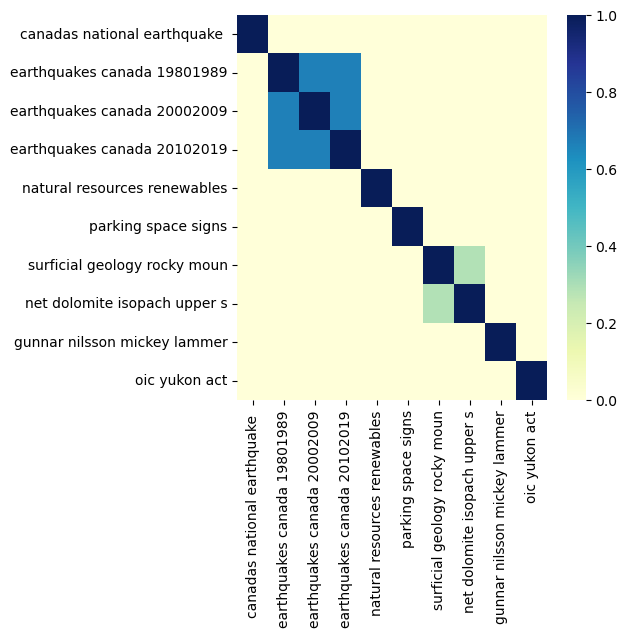

In [54]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_list)
arr = X.toarray()
create_heatmap(cosine_similarity(arr))


In [56]:
# Let's take a look at the similarity socres 

from scipy import stats
sim =cosine_similarity(arr)
"""
for a in sim: #do not need the loop at this point, but looks prettier
    print(stats.describe(a))
test = np.array(sim)
"""
print(sim.shape)
print(sim)

(10, 10)
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.66666667 0.66666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.66666667 1.         0.66666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.66666667 0.66666667 1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.28603878 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.28603878 1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.         0.  

### Baseline model: Term Frequency - Inverse Document Frequency (TF-IDF) 
TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.TF-IDF vectors are an extension of the one-hot encoding model. 
This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. TF-IDF is very similart

Limitations
- It is only useful as a lexical level feature.
- Synonymities are neglected.
- It doesn't capture semantic.
- The highest TF-IDF score may not make sense with the topic of the document, since IDF gives high weight if the DF of a term is low.
- It neglects the sequence of the terms.


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
labels = [text[:28] for text in text_list]
#print(labels)
def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)


In [59]:
# Prepare and slice the data for model comparison   
df = df[['features_properties_id', 'features_properties_title_en','title_en_cleaned', 'text_en_cleaned']]
df['id'] = range(0, df.shape[0])
df_test = df.iloc[[193, 365,495, 1001, 1002, 1003, 1004, 1005, 1006, 1007]]
# Covert to list 
df_pd = df_test.to_numpy()
text_list = df_pd[ :, 2].tolist() # training using title 
#text_list = df_pd[ :, 3].tolist() # training using text 

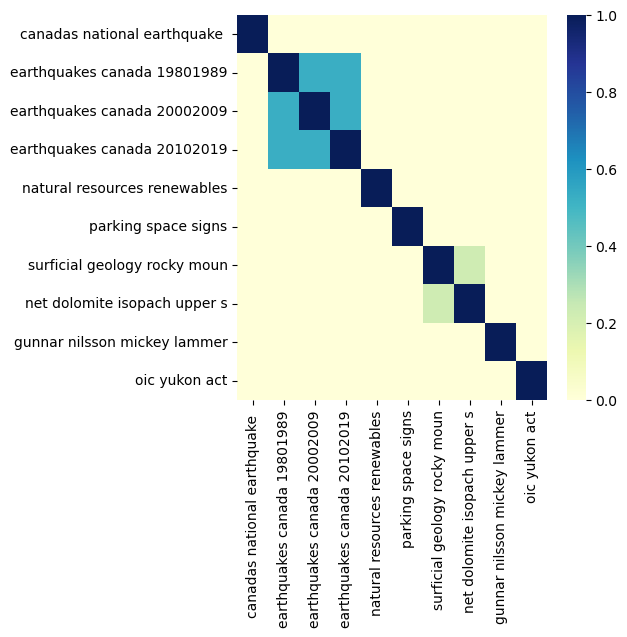

In [60]:
# Vectorizing tf-idf 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_list)
arr = X.toarray()

create_heatmap(cosine_similarity(arr))

### Model 2: Word2Vec + Smooth Inverse Frequency + Cosine Similarity 

Pre-trained word2Vec model can be obtained from the [Spacy](https://spacy.io/models) or [Gensim] packages. [See a comparison of different NLP python packages](https://medium.com/activewizards-machine-learning-company/comparison-of-top-6-python-nlp-libraries-c4ce160237eb). 

Some useful links: 
- https://stackoverflow.com/questions/41623174/using-word2vec-to-calculate-sentence-similarity
- https://stackoverflow.com/questions/65852710/text-similarity-using-word2vec
- https://towardsdatascience.com/how-to-compute-sentence-similarity-using-bert-and-word2vec-ab0663a5d64
- https://stackoverflow.com/questions/22129943/how-to-calculate-the-sentence-similarity-using-word2vec-model-of-gensim-with-pyt
- [Youtube tutorials using gensim and Spacy for word2vec](https://www.youtube.com/watch?v=Il04RjS-9-8)


In [ ]:

"""Installation Spacy 
!conda install -c conda-forge spacy=3.3.1
!python -m spacy download en_core_web_md # Must disconnect from VPN and run twice if it falls the first time 

!conda install -c anaconda gensim
#genism word2vec: https://github.com/adsieg/text_similarity/blob/master/EMBEDDING%20(word2vec%2C%20FastText%2C%20Glove%2C%20HomeMadeEmbedding).ipynb
"""

In [ ]:
!python -m spacy download en_core_web_lg
import gensim
import spacy
# python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Slice the data   
df = df[['features_properties_id', 'features_properties_title_en', 'text']]
df['id'] = range(0, df.shape[0])
#df_test = df.iloc[1000:1010]
df_test = df
#print(df_test)

In [40]:
labels = [text[:28] for text in text_list]
print(labels)

def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)

['canadas national earthquake ', 'earthquakes canada 19801989 ', 'earthquakes canada 20002009 ', 'earthquakes canada 20102019 ', 'natural resources renewables', 'parking space signs location', 'surficial geology rocky moun', 'net dolomite isopach upper s', 'gunnar nilsson mickey lammer', 'oic yukon act orders council']


In [ ]:
# Vectorization 
ref_sent = df_test.loc[df_test['id']==1001, "features_properties_title_en"].iloc[0]
ref_sent_vec = nlp(ref_sent)
all_docs = [nlp(row) for row in df_test['features_properties_title_en']]  

In [ ]:
sims = []
for i in range(len(all_docs)):
    row = []
    for j in range(len(all_docs)):
        row.append(all_docs[i].similarity(all_docs[j]))
    sims.append(row)
#sim_df = pd.DataFrame (sims, columns = ['col1', 'col2','col3','col4','col5','col6','col7','col8','col9','col10',])

[[1.0, 0.9210883469177495, 0.92177818887327, 0.9221574655149865, 0.7559306187547226, 0.7248616314572534, 0.7357962634175914, 0.6812221727486651, 0.6060168730976837, 0.7671558736014542], [0.9210883469177495, 1.0, 0.9993324598032712, 0.998581369279358, 0.7143363346157151, 0.6631264298416039, 0.746353102196704, 0.7175383517947934, 0.5765332229290109, 0.6961135363747726], [0.92177818887327, 0.9993324598032712, 1.0, 0.9990514521935168, 0.717355163222967, 0.6665471352062933, 0.7477605232550155, 0.7178989588071958, 0.5765756299222369, 0.6989079304988303], [0.9221574655149865, 0.998581369279358, 0.9990514521935168, 1.0, 0.7179109649288284, 0.6669207845560335, 0.7465423248606171, 0.7151357342070906, 0.5755382988495407, 0.6982589197449651], [0.7559306187547226, 0.7143363346157151, 0.717355163222967, 0.7179109649288284, 1.0, 0.7509299653515151, 0.7065418160408912, 0.6600063940073645, 0.5991685989818891, 0.7278500768920245], [0.7248616314572534, 0.6631264298416039, 0.6665471352062933, 0.6669207845

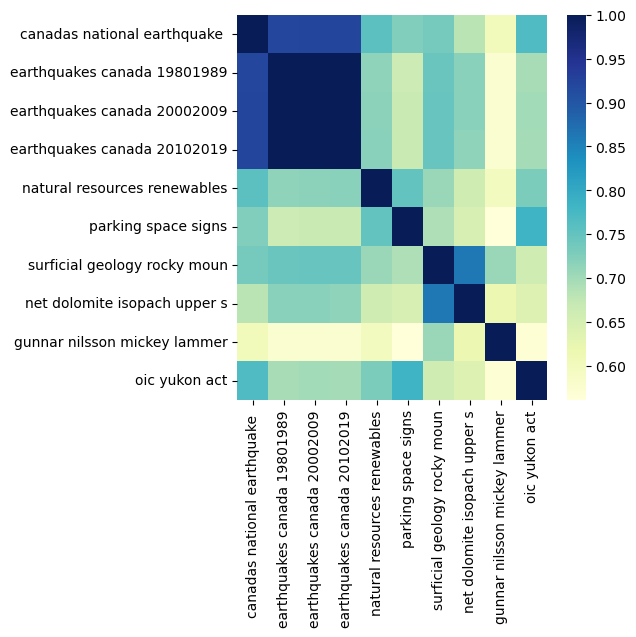

In [67]:
# Make heatmap 
sim_df = pd.read_csv('sim.csv')
sim_df= sim_df.iloc[: , 1:]
#print(sim_df)
# Covert to list 
sim_df = sim_df.to_numpy()
sim = sim_df[ :, 0:11].tolist() # training using text 
print(sim)
create_heatmap(sim)

### Model 3: Sentence Transfer Learning - Sentence BERT 
Contextual embedding methods like BERT learn sequence-level semantics by considering the sequence of all words in the document. As a result, these techniques learn different representations for polysemous words like ‘bank’ in the above example, based on their context. 

[Sentence BERT](https://www.sbert.net/) is a modified BERT network that uses siamese and triplet network structures to derive semantically meaningful sentence embeddings. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT. 




In [ ]:
# Installation
# !conda install -c conda-forge sentence-transformers

In [19]:
# Download the 'stsb-roberta-large' model 
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('stsb-roberta-large')

c:\Users\xcai\Anaconda3\envs\DS\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
# Prepare and slice the data for model comparison   
df = df[['features_properties_id', 'features_properties_title_en','title_en_cleaned', 'text_en_cleaned']]
df['id'] = range(0, df.shape[0])
df_test = df.iloc[[193, 365,495, 1001, 1002, 1003, 1004, 1005, 1006, 1007]]
# Covert to list 
df_pd = df_test.to_numpy()
text_list = df_pd[ :, 2].tolist() # training using title 
#text_list = df_pd[ :, 3].tolist() # training using text 

In [63]:
embeddings = model.encode(text_list, convert_to_tensor=True)
labels = [text[:28] for text in text_list]
print(labels)

def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)
  
  

['canadas national earthquake ', 'earthquakes canada 19801989', 'earthquakes canada 20002009', 'earthquakes canada 20102019', 'natural resources renewables', 'parking space signs', 'surficial geology rocky moun', 'net dolomite isopach upper s', 'gunnar nilsson mickey lammer', 'oic yukon act']


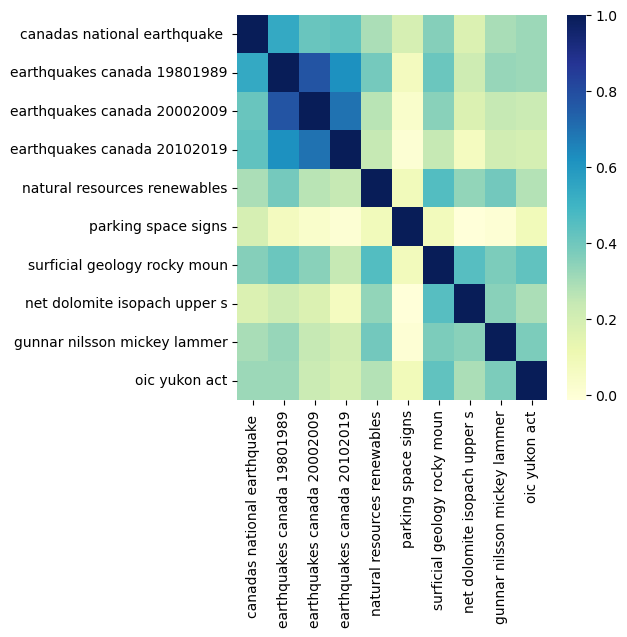

In [65]:
similarity = []
for i in range(len(text_list)):
    row = []
    for j in range(len(text_list)):
        row.append(util.pytorch_cos_sim(embeddings[i], embeddings[j]).item())
    similarity.append(row)

create_heatmap(similarity)